In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))


import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

2.3.0


In [2]:
# data = pd.read_csv('https://raw.githubusercontent.com/susanli2016/PyCon-Canada-2019-NLP-Tutorial/master/bbc-text.csv')
# data.to_csv('data.csv')
data=pd.read_csv('data.csv')

In [3]:
data.head()

,Unnamed: 0,category,text
0,0,tech,tv future in the hands of viewers with home th...
1,1,business,worldcom boss left books alone former worldc...
2,2,sport,tigers wary of farrell gamble leicester say ...
3,3,sport,yeading face newcastle in fa cup premiership s...
4,4,entertainment,ocean s twelve raids box office ocean s twelve...


In [4]:
def preprocess_text(x):
    all_x=""
    for t in x.split():
        if t not in STOPWORDS:
            all_x+=t+' '
    return all_x
data['text2']=data['text'].apply(lambda x: preprocess_text(x))    

In [5]:
data.head()

,Unnamed: 0,category,text,text2
0,0,tech,tv future in the hands of viewers with home th...,tv future hands viewers home theatre systems p...
1,1,business,worldcom boss left books alone former worldc...,worldcom boss left books alone former worldcom...
2,2,sport,tigers wary of farrell gamble leicester say ...,tigers wary farrell gamble leicester say rushe...
3,3,sport,yeading face newcastle in fa cup premiership s...,yeading face newcastle fa cup premiership side...
4,4,entertainment,ocean s twelve raids box office ocean s twelve...,ocean twelve raids box office ocean twelve cri...


In [6]:
#HyperParameter
vocab_size=5000
embedding_dim=64
max_length=200
trunc_type='post'
padding_type='post'
oov_tok='<OOV>'

In [7]:
labels=list(data['category'])
articles=list(data['text2'])

In [8]:
len(labels),len(articles)

(2225, 2225)

In [9]:
train_articles,val_articles,train_labels,val_labels=train_test_split(articles,labels,\
                                                                     stratify=labels,test_size=0.2)

In [10]:
print("Train size is {}".format(len(train_articles)))
print("Val   size is {}".format(len(val_articles)))

Train size is 1780
Val   size is 445


In [57]:
#tokenize
tokenizer=Tokenizer(num_words=vocab_size,oov_token=oov_tok)
tokenizer.fit_on_texts(train_articles)

word_index=tokenizer.word_index
dict(list(word_index.items())[:10])

{'<OOV>': 1,
 'said': 2,
 'mr': 3,
 'would': 4,
 'year': 5,
 'also': 6,
 'new': 7,
 'people': 8,
 'us': 9,
 'one': 10}

In [58]:
#converting to sequence and padding
train_seq=tokenizer.texts_to_sequences(train_articles)
train_pad=tf.keras.preprocessing.sequence.pad_sequences(train_seq,
                                                        maxlen=max_length,
                                                        padding='post',
                                                        truncating='post')

val_seq=tokenizer.texts_to_sequences(val_articles)
val_pad=pad_sequences(val_seq,
                     maxlen=max_length,
                     padding='post',
                     truncating='post')

In [59]:
#tokenize labels
label_tokenizer=Tokenizer()
label_tokenizer.fit_on_texts(labels)

word_index=label_tokenizer.word_index
dict(list(word_index.items())[:10])

{'sport': 1, 'business': 2, 'politics': 3, 'tech': 4, 'entertainment': 5}

In [63]:
#convert labels to Sequence
train_label_seq=np.array(label_tokenizer.texts_to_sequences(train_labels))
val_label_seq=np.array(label_tokenizer.texts_to_sequences(val_labels))

We build a tf.keras.Sequential model and start with an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices into sequences of vectors. After training, words with similar meanings often have the similar vectors.

The Bidirectional wrapper is used with a LSTM layer, this propagates the input forwards and backwards through the LSTM layer and then concatenates the outputs. This helps LSTM to learn long term dependencies. We then fit it to a dense neural network to do classification.

We use relu in place of tahn function since they are very good alternatives of each other.


We add a Dense layer with 6 units and softmax activation. When we have multiple outputs, softmax converts outputs layers into a probability distribution.

In [65]:
model = tf.keras.Sequential([
    # Add an Embedding layer expecting input vocab of size 5000, 
    # and output embedding dimension of size 64 we set at the top
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
#    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    # use ReLU in place of tanh function since they are very good alternatives of each other.
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    # Add a Dense layer with 6 units and softmax activation.
    # When we have multiple outputs, softmax convert outputs layers into a probability distribution.
    tf.keras.layers.Dense(6, activation='softmax')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          320000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 390       
Total params: 394,694
Trainable params: 394,694
Non-trainable params: 0
_________________________________________________________________


We have 5 labels in total, but because we did not one-hot encode labels, we have to use sparse_categorical_crossentropy as loss function, it seems to think 0 is a possible label as well, while the tokenizer object which tokenizes starting with integer 1, instead of integer 0. As a result, the last Dense layer needs outputs for labels 0, 1, 2, 3, 4, 5 although 0 has never been used.

If you want the last Dense layer to be 5, you will need to subtract 1 from the training and validation labels.

I decided to leave it as it is.

I decided to train 10 epochs, and it is plenty of epochs as you will see.

In [67]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
num_epochs = 10
history = model.fit(train_pad,
                    train_label_seq,
                    epochs=num_epochs, 
                    validation_data=(val_pad, val_label_seq),
                    verbose=2)

Epoch 1/10
56/56 - 4s - loss: 1.5601 - accuracy: 0.2978 - val_loss: 1.3023 - val_accuracy: 0.5169
Epoch 2/10
56/56 - 3s - loss: 0.8753 - accuracy: 0.7404 - val_loss: 0.8128 - val_accuracy: 0.7640
Epoch 3/10
56/56 - 3s - loss: 0.3966 - accuracy: 0.8983 - val_loss: 0.4093 - val_accuracy: 0.8629
Epoch 4/10
56/56 - 4s - loss: 0.1474 - accuracy: 0.9646 - val_loss: 0.2876 - val_accuracy: 0.9079
Epoch 5/10
56/56 - 4s - loss: 0.0894 - accuracy: 0.9697 - val_loss: 0.2725 - val_accuracy: 0.9124
Epoch 6/10
56/56 - 4s - loss: 0.0554 - accuracy: 0.9843 - val_loss: 0.2477 - val_accuracy: 0.9281
Epoch 7/10
56/56 - 4s - loss: 0.0212 - accuracy: 0.9955 - val_loss: 0.2436 - val_accuracy: 0.9326
Epoch 8/10
56/56 - 4s - loss: 0.0089 - accuracy: 0.9978 - val_loss: 0.2373 - val_accuracy: 0.9416
Epoch 9/10
56/56 - 4s - loss: 0.0035 - accuracy: 0.9994 - val_loss: 0.2427 - val_accuracy: 0.9416
Epoch 10/10
56/56 - 4s - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.2639 - val_accuracy: 0.9393


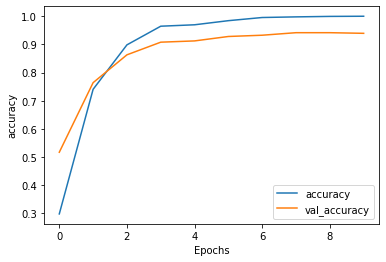

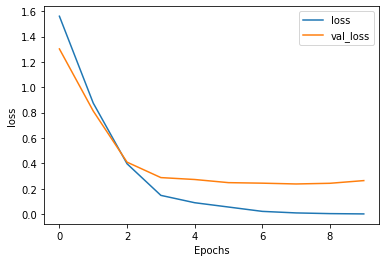

In [70]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
    
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")